In [5]:
from optimalflow.autoPipe import autoPipe
import pandas as pd
from optimalflow.funcPP import PPtools
from optimalflow.autoPP import dynaPreprocessing

from optimalflow.autoFS import dynaFS_clf
from optimalflow.autoCV import evaluate_model,dynaClassifier,dynaRegressor
# Import sample data
df = pd.read_csv('../data/preprocessing/breast_cancer.csv')
# Custom settings for the autoPP module
custom_parameters = {
    "scaler" : ["standard"],
    # threshold number of category dimension
    "encode_band" : [20],
    # low dimension encoding
    "low_encode" : ["onehot"], 
    # high dimension encoding
    "high_encode" : ["frequency", "mean"],
    "winsorizer" : [(0.1,0.1)],
    "sparsity" : [0],
    "cols" : [1000]
}
#Reset autoCV estimators default parameters
from optimalflow.utilis_func import pipeline_splitting_rule, update_parameters,reset_parameters
reset_parameters()

# # Modify some autoCV estimators default parameters
# update_parameters(mode = "cls", estimator_name = "mlp", hidden_layer_sizes = [10],activation=["relu"],learning_rate = ["constant"],solver = ["sgd"])
# update_parameters(mode = "cls", estimator_name = "svm", C=[0.1],kernel=["linear"])
# update_parameters(mode = "cls", estimator_name = "ada", n_estimators =[50],learning_rate=[1])
# update_parameters(mode = "cls", estimator_name = "rf", n_estimators =[50],max_depth=[2])
# update_parameters(mode = "cls", estimator_name = "gb", n_estimators =[50],max_depth=[2],learning_rate=[1])
# update_parameters(mode = "cls", estimator_name = "xgb", n_estimators =[50],max_depth=[2],learning_rate=[1])
# Create Pipeline Cluster Traversal Experiments by autoPipe
pipe = autoPipe(
[("autoPP",dynaPreprocessing(custom_parameters = custom_parameters, label_col = 'diagnosis', model_type = "cls")),
("datasets_splitting",pipeline_splitting_rule(val_size = 0.2, test_size = 0.2, random_state = 13)),
("autoFS",dynaFS_clf(custom_selectors = ['rfe_rf'],fs_num = 8, random_state=13, cv = 5, in_pipeline = True, input_from_file = False)),
("autoCV",dynaClassifier(custom_estimators =['svm','rf','ada','xgb'],random_state = 13,cv_num = 5,in_pipeline = True, input_from_file = False)),
("model_evaluate",evaluate_model(model_type = "cls"))])

Done with the parameters reset.


In [6]:
# Notebook display settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns',None,'display.max_rows',None)
pd.set_option('max_colwidth', -1)

# Get outputs into DICT_PREPROCESSING,DICT_FEATURE_SELECTION,DICT_MODELS_EVALUATION,DICT_DATA,dyna_report. More details about the attributes in https://optimal-flow.readthedocs.io/en/latest/autoPipe.html#module-optimalflow.autoPipe
DICT_PREPROCESSING,DICT_FEATURE_SELECTION,DICT_MODELS_EVALUATION,DICT_DATA,dyna_report= pipe.fit(df)

Now in Progress - autoFS & autoCV Iteration: Estimate about 0.0 minutes left  [####################] 100.0%
The top 5 Models with Best Performance Metrics:
     Dataset Model_Name  \
2  Dataset_0  ada         
0  Dataset_0  svm         
1  Dataset_0  rf          
3  Dataset_0  xgb         

                                                        Best_Parameters  \
2  [('learning_rate', 0.1), ('n_estimators', 50), ('random_state', 13)]   
0  [('C', 10), ('kernel', 'rbf')]                                         
1  [('max_depth', 8), ('n_estimators', 250), ('random_state', 13)]        
3  [('learning_rate', 0.1), ('max_depth', 3), ('n_estimators', 100)]      

   Accuracy  Precision    Recall  Latency  
2  0.877193  0.879927   0.877193  8.0      
0  0.859649  0.862638   0.859649  3.0      
1  0.824561  0.827680   0.824561  46.9     
3  0.824561  0.824651   0.824561  2.0      


In [7]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
# Save the outputs as pickles for further analysis and visualization
save_obj(DICT_PREPROCESSING,"dict_preprocess")
save_obj(DICT_DATA,"dict_data")
save_obj(DICT_MODELS_EVALUATION,"dict_models_evaluate")
save_obj(dyna_report,"dyna_report")

<module 'matplotlib.pyplot' from 'C:\\Users\\Jessi\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\Jessi\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\Jessi\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\Jessi\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\Jessi\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

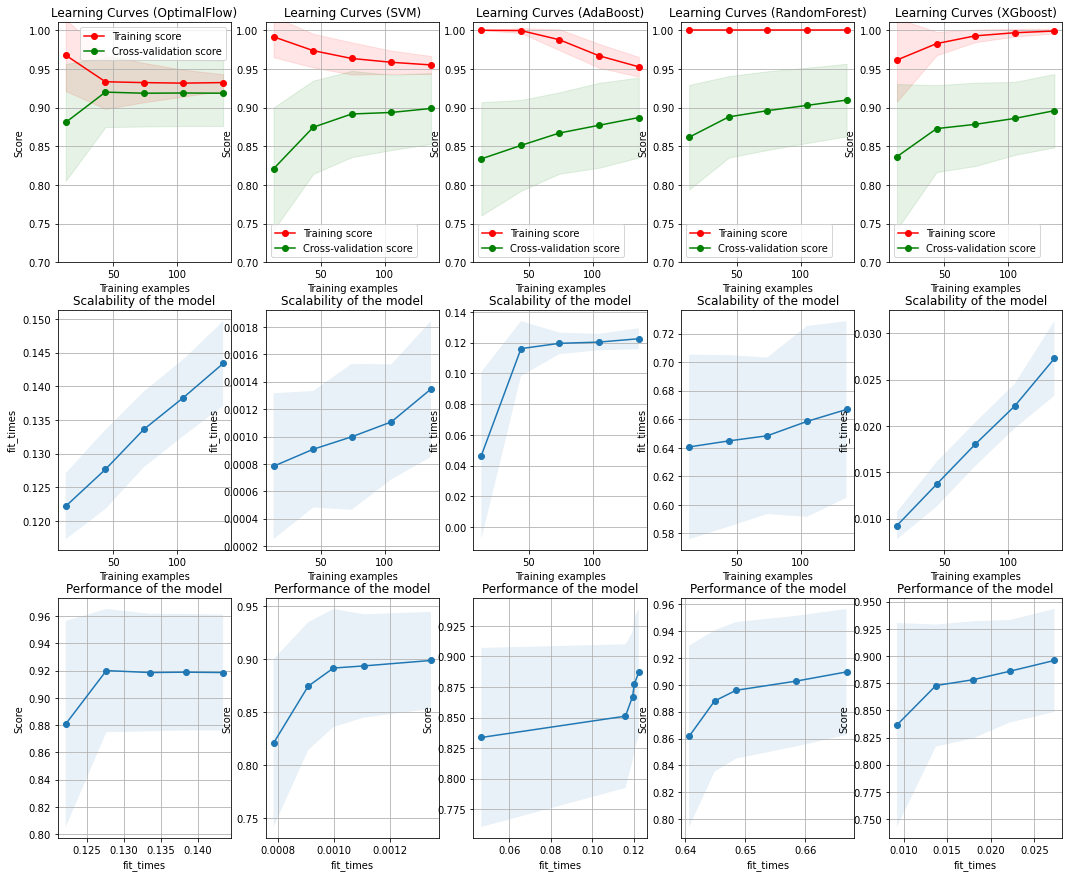

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression,LinearRegression,HuberRegressor,RidgeCV,RidgeClassifierCV,LassoCV,SGDRegressor,SGDClassifier
from sklearn.svm import SVC,SVR,LinearSVR,LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,AdaBoostRegressor,AdaBoostClassifier,HistGradientBoostingRegressor,HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(5, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 5, figsize=(18, 15))

# X, y = load_digits(return_X_y=True)

dict_data = load_obj("../dict_data")
X = dict_data["Dataset_563"]['DICT_Train']['X']
y = dict_data["Dataset_563"]['DICT_Train']['y']

X_pd = X.to_numpy()
y_pd = y.to_numpy()

title = "Learning Curves (OptimalFlow)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPClassifier(random_state=13, activation = 'relu',hidden_layer_sizes = (10,),learning_rate = 'constant',solver='sgd')
plot_learning_curve(estimator, title, X_pd, y_pd, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

dict_data = load_obj("./dict_data")
X = dict_data["Dataset_0"]['DICT_Train']['X']
y = dict_data["Dataset_0"]['DICT_Train']['y']

X_pd = X.to_numpy()
y_pd = y.to_numpy()

title = r"Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVC(C = 10, kernel ='rbf')
plot_learning_curve(estimator, title, X_pd, y_pd, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (AdaBoost)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = AdaBoostClassifier(learning_rate = 0.1,n_estimators=50,random_state = 13)
plot_learning_curve(estimator, title, X_pd, y_pd, axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (RandomForest)"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(max_depth= 8,n_estimators=250,random_state = 13)
plot_learning_curve(estimator, title, X_pd, y_pd, axes=axes[:, 3], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (XGboost)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = xgb.XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=100)
plot_learning_curve(estimator, title, X_pd, y_pd, axes=axes[:, 4], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

Encoding top 8 features parrallel coordinates plot

,concave points_mean,concavity_mean,perimeter_mean,radius_mean,smoothness_mean,onehot_Size_2_9-11,onehot_Treatment_no-recurrence-events,onehot_Treatment_recurrence-events
204,-0.471719,-0.251479,-0.635735,-0.661898,0.140419,-0.190347,0.650297,-0.650297
198,0.457963,0.229896,1.610033,1.583382,-1.156829,-0.190347,0.650297,-0.650297
93,-0.799675,-0.870434,-0.369107,-0.333974,0.369821,-0.190347,0.650297,-0.650297
78,1.638730,1.754635,1.716491,1.700498,1.566312,-0.190347,-1.537760,1.537760
128,1.013062,0.266748,0.258992,0.218145,1.521331,-0.190347,-1.537760,1.537760
268,-1.166696,-0.881797,-0.573312,-0.528051,-0.345374,-0.190347,0.650297,-0.650297
273,-1.232224,-1.181677,-1.331095,-1.327786,-0.694426,-0.190347,0.650297,-0.650297
10,-0.628608,-0.974079,0.409968,0.525992,-1.442008,-0.190347,0.650297,-0.650297
282,1.306049,1.016066,1.595516,1.656998,0.504764,-0.190347,0.650297,-0.650297
38,-0.762185,-1.112427,0.063497,0.181337,-0.379560,-0.190347,0.650297,-0.650297


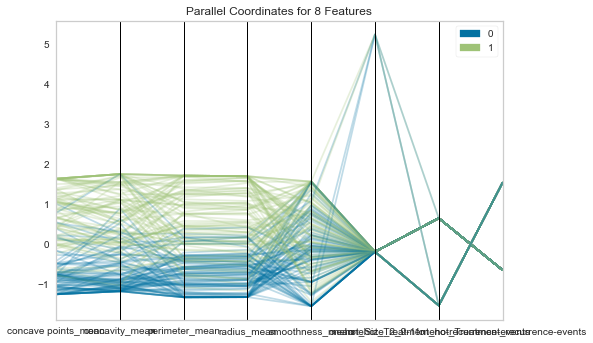

In [12]:

from yellowbrick.features import ParallelCoordinates
dict_data = load_obj("./dict_data")
X = dict_data["Dataset_0"]['DICT_Train']['X']
y = dict_data["Dataset_0"]['DICT_Train']['y']
# Instantiate the visualizer
visualizer = ParallelCoordinates(shuffle=True)
# Fit the visualizer and display it
a = visualizer.fit_transform(X, y)
visualizer.show()

PCA approach for feature preprocessing

In [2]:
from optimalflow.autoPipe import autoPipe
import pandas as pd
from optimalflow.funcPP import PPtools
from optimalflow.autoPP import dynaPreprocessing

from optimalflow.autoFS import dynaFS_clf
from optimalflow.autoCV import evaluate_model,dynaClassifier,dynaRegressor
# Import sample data
df = pd.read_csv('../data/preprocessing/breast_cancer.csv')
# Custom settings for the autoPP module
custom_parameters = {
    "scaler" : ["standard"],
    # threshold number of category dimension
    "encode_band" : [20],
    # low dimension encoding
    "low_encode" : ["onehot"], 
    # high dimension encoding
    "high_encode" : ["frequency", "mean"],
    "winsorizer" : [(0.1,0.1)],
    "sparsity" : [0],
    "cols" : [1000]
}
#Reset autoCV estimators default parameters
from optimalflow.utilis_func import pipeline_splitting_rule, update_parameters,reset_parameters
reset_parameters()
pp = dynaPreprocessing(custom_parameters = custom_parameters, label_col = 'diagnosis', model_type = "cls")
DICT_PREP_DF,DICT_PREP_INFO = pp.fit(df)
 

Now in Progress - Data Preprocessing Ensemble Iteration: Estimate about 0.0 minutes left  [####################] 100.0%


In [5]:
DICT_PREP_DF['Dataset_0'].head()

,diagnosis,Size_3,area_mean,compactness_mean,concave points_mean,concavity_mean,fractal_dimension_mean,perimeter_mean,radius_mean,smoothness_mean,...,onehot_Treatment_no-recurrence-events,onehot_Treatment_recurrence-events,onehot_Type_1_ge40,onehot_Type_1_lt40,onehot_Type_1_premeno,onehot_Type_2_NaN,onehot_Type_2_no,onehot_Type_2_yes,onehot_Type_3_no,onehot_Type_3_yes
0,1,1.290564,1.151477,1.730765,1.638730,1.754635,1.875709,1.382601,1.185188,1.566312,...,-1.537760,1.537760,-0.906452,-0.158397,0.95219,-0.169638,-1.862458,2.026609,0.558504,-0.558504
1,1,-1.423416,1.823311,-0.679975,0.535147,-0.146298,-1.009702,1.716491,1.700498,-1.200910,...,0.650297,-0.650297,1.103202,-0.158397,-1.05021,-0.169638,0.536925,-0.493435,0.558504,-0.558504
2,1,-0.066426,1.823311,1.163585,1.638730,1.550416,-0.447521,1.716491,1.700498,1.035538,...,-1.537760,1.537760,1.103202,-0.158397,-1.05021,-0.169638,0.536925,-0.493435,0.558504,-0.558504
3,1,1.290564,-1.011406,1.730765,1.638730,1.754635,1.875709,-0.805583,-1.013246,1.566312,...,0.650297,-0.650297,-0.906452,-0.158397,0.95219,-0.169638,-1.862458,2.026609,-1.790498,1.790498
4,1,-0.066426,1.823311,0.548763,1.610377,1.559629,-0.643946,1.716491,1.700498,0.198894,...,-1.537760,1.537760,-0.906452,-0.158397,0.95219,-0.169638,-1.862458,2.026609,0.558504,-0.558504


In [13]:
df_pca = DICT_PREP_DF['Dataset_0']
df_pca_y = df_pca.loc[:,df_pca.columns == 'diagnosis']
df_pca_x = df_pca.loc[:, df_pca.columns != 'diagnosis']

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(df_pca_x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8'])

In [36]:
principalDf.head(100)

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
0,4.276126,1.826563,-0.819765,-2.596251,0.447302,1.361710,0.766594,-0.005146
1,1.220786,-2.681594,1.058005,1.781619,-2.150700,0.928444,-1.164957,1.894855
2,3.842787,-0.450275,1.440029,1.734303,1.999102,2.160599,0.339868,-1.328922
3,2.233449,2.628336,-1.008569,-3.747512,1.528903,-1.163568,-1.409852,-0.659951
4,3.307564,3.286954,-1.617440,1.311211,0.201913,2.707955,0.294555,0.117422
...,...,...,...,...,...,...,...,...
95,3.429632,-0.077282,-1.615157,2.972959,0.112860,-3.068089,0.833582,0.883012
96,-1.771486,-0.163423,-1.168538,-0.897972,1.491092,0.793144,1.339871,0.402897
97,-3.382115,-1.963739,-0.438733,-0.083664,1.977763,-0.566130,-1.185012,-1.144573
98,-2.224428,1.636210,1.605791,-0.739559,-2.180946,-0.509961,3.341978,0.310759


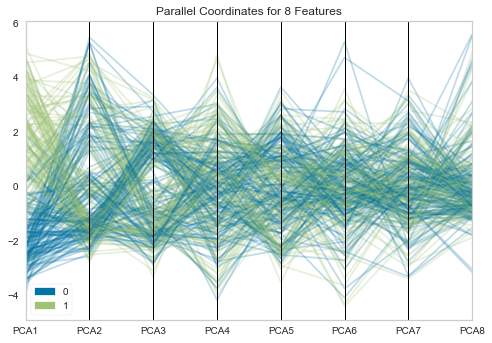

In [59]:
from yellowbrick.features import ParallelCoordinates
X = principalDf
y = df_pca_y.loc[:,"diagnosis"]
# Instantiate the visualizer
visualizer = ParallelCoordinates(shuffle=True)
# Fit the visualizer and display it
a = visualizer.fit_transform(X, y)
visualizer.show()